<h1 align="center">Bike Rent</h1>

In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

#### **Lets Read In The Dataset**

In [2]:
dailyData = pd.read_csv("day.csv")

## Data Summary

As a first step lets do three simple steps on the dataset

 - Size of the dataset
 - Get a glimpse of data by printing few rows of it.
 - What type of variables contribute our data

#### **Shape Of The Dataset**

In [3]:
dailyData.shape

(731, 16)

#### **Sample Of First Few Rows**

In [4]:
dailyData.head(2)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801


#### **Variables Data Type**

In [5]:
dailyData.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

## Feature Engineering

As we see from the above results, the columns "season","holiday","workingday" and "weather" should be of "categorical" data type.But the current data type is "int" for those columns. Let us transform the dataset in the following ways so that we can get started up with our EDA

 - Coerce the datatype of "season","holiday","workingday" and weather to category.

#### **Creating New Columns From "Datetime" Column**

In [6]:
dailyData["weekday"] = dailyData.dteday.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
dailyData["month"] = dailyData.dteday.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
dailyData["season"] = dailyData.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
dailyData["weather"] = dailyData.weathersit.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })

#### **Coercing To Category Type**

In [7]:
categoryVariableList = ["weekday","month","season","weather","holiday","workingday"]
for var in categoryVariableList:
    dailyData[var] = dailyData[var].astype("category")

In [8]:
dailyData.dtypes

instant          int64
dteday          object
season        category
yr               int64
mnth             int64
holiday       category
weekday       category
workingday    category
weathersit       int64
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
month         category
weather       category
dtype: object

## Missing Values Analysis

Once we get hang of the data and columns, next step we generally take is to find out whether we have any missing values in our data. Luckily we dont have any missing value in the dataset. One way which I generally prefer to visualize missing value in the dataset is through "missingno".

Its a quiet handy library to quickly visualize variables for missing values. As I mentioned earlier we got lucky this time as there no missing value in the dataset.

## Skewness In Distribution ##

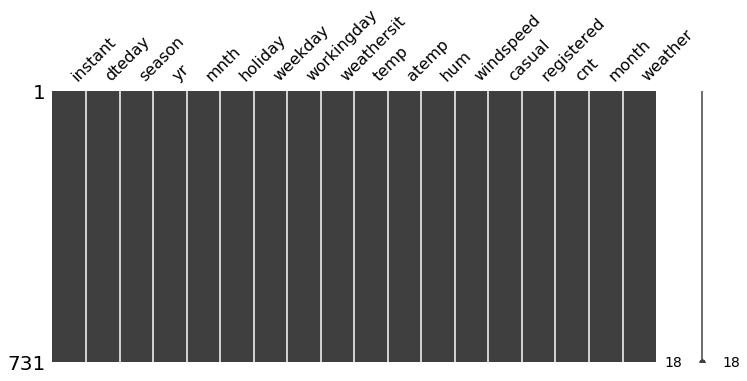

In [9]:
msno.matrix(dailyData,figsize=(12,5))

## Outliers Analysis

At first look, "count" variable contains lot of outlier data points which skews the distribution towards right (as there are more data points beyond Outer Quartile Limit).But in addition to that, following inferences can also been made from the simple boxplots given below.

 - Spring season has got relatively lower count.The dip in median value
   in boxplot gives evidence for it.
 - Most of the outlier points are mainly contributed from "Working Day" than "Non Working Day".

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

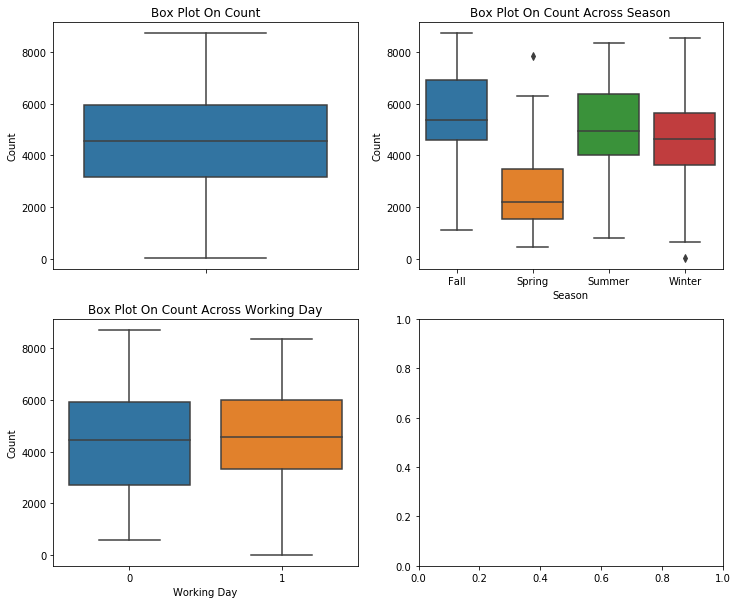

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=dailyData,y="cnt",orient="v",ax=axes[0][0])
sn.boxplot(data=dailyData,y="cnt",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=dailyData,y="cnt",x="workingday",orient="v",ax=axes[1][0])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

#### **Lets Remove Outliers In The Count Column**

In [11]:
dailyDataWithoutOutliers = dailyData[np.abs(dailyData["cnt"]-dailyData["cnt"].mean())<=(3*dailyData["cnt"].std())] 

In [12]:
print ("Shape Of The Before Ouliers: ",dailyData.shape)
print ("Shape Of The After Ouliers: ",dailyDataWithoutOutliers.shape)

Shape Of The Before Ouliers:  (731, 18)
Shape Of The After Ouliers:  (731, 18)


## Correlation Analysis

One common to understand how a dependent variable is influenced by features (numerical) is to fibd a correlation matrix between them. Lets plot a correlation plot between "count" and ["temp","atemp","humidity","windspeed"].

 - temp and humidity features has got positive and negative correlation
   with count respectively.Although the correlation between them are not
   very prominent still the count variable has got little dependency on
   "temp" and "humidity".
 - windspeed is not gonna be really useful numerical feature and it is visible from it correlation value with "count"
 - "atemp" is variable is not taken into since "atemp" and "temp" has got strong correlation with each other. During model building any one of the variable has to be dropped since they will exhibit multicollinearity in the data.
 - "Casual" and "Registered" are also not taken into account since they are leakage variables in nature and need to dropped during model building.

Regression plot in seaborn is one useful way to depict the relationship between two features. Here we consider "count" vs "temp", "humidity", "windspeed".

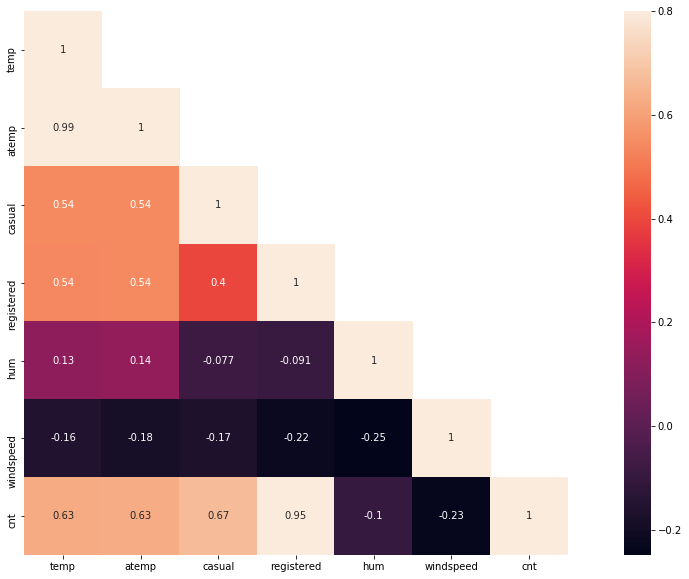

In [13]:
corrMatt = dailyData[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

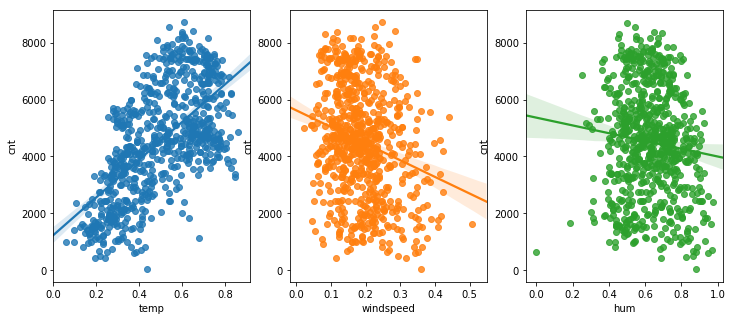

In [14]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sn.regplot(x="temp", y="cnt", data=dailyData,ax=ax1)
sn.regplot(x="windspeed", y="cnt", data=dailyData,ax=ax2)
sn.regplot(x="hum", y="cnt", data=dailyData,ax=ax3)

## Visualizing Distribution Of Data
As it is visible from the below figures that "count" variable is skewed towards right. It is desirable to have Normal distribution as most of the machine learning techniques require dependent variable to be Normal. One possible solution is to take log transformation on "count" variable after removing outlier data points. After the transformation the data looks lot better but still not ideally following normal distribution.

((array([-3.10612952, -2.83371839, -2.68121219, -2.57340905, -2.48915191,
         -2.41955673, -2.36001798, -2.30782877, -2.26125818, -2.21912992,
         -2.18060696, -2.14507173, -2.11205508, -2.08119197, -2.05219258,
         -2.0248228 , -1.99889075, -1.97423711, -1.95072808, -1.92825019,
         -1.90670633, -1.88601273, -1.8660966 , -1.84689427, -1.82834975,
         -1.81041348, -1.79304141, -1.77619419, -1.75983653, -1.74393663,
         -1.72846577, -1.71339788, -1.69870925, -1.68437825, -1.67038506,
         -1.6567115 , -1.64334086, -1.63025771, -1.6174478 , -1.60489794,
         -1.59259587, -1.58053022, -1.56869036, -1.55706641, -1.54564912,
         -1.53442983, -1.52340042, -1.51255328, -1.50188124, -1.49137757,
         -1.4810359 , -1.47085025, -1.46081495, -1.45092464, -1.44117426,
         -1.431559  , -1.4220743 , -1.41271583, -1.40347947, -1.39436132,
         -1.38535765, -1.3764649 , -1.36767969, -1.35899879, -1.35041911,
         -1.3419377 , -1.33355173, -1.

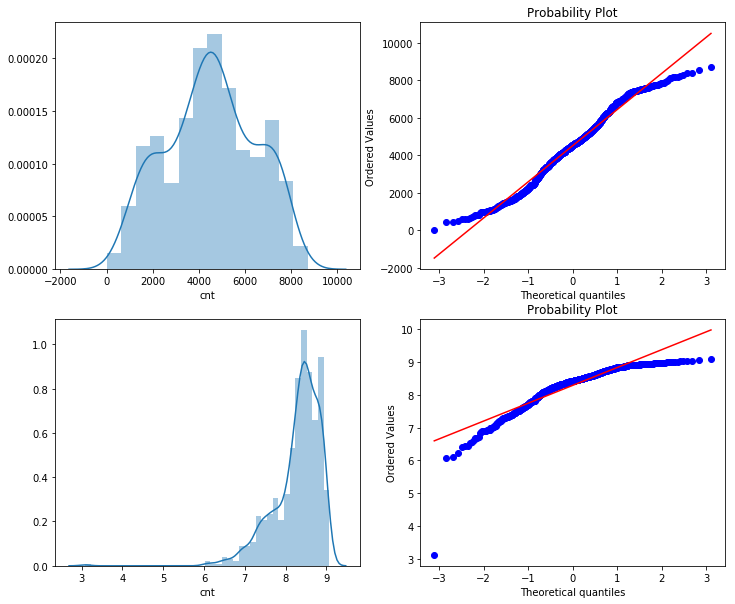

In [15]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sn.distplot(dailyData["cnt"],ax=axes[0][0])
stats.probplot(dailyData["cnt"], dist='norm', fit=True, plot=axes[0][1])
sn.distplot(np.log(dailyDataWithoutOutliers["cnt"]),ax=axes[1][0])
stats.probplot(np.log1p(dailyDataWithoutOutliers["cnt"]), dist='norm', fit=True, plot=axes[1][1])

## Visualizing Count Vs (Month,Season,Weekday,Usertype)

 - It is quiet obvious that people tend to rent bike during summer
   season since it is really conducive to ride bike at that
   season.Therefore June, July and August has got relatively higher
   demand for bicycle.
 

[Text(0, 0.5, 'Avearage Count'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Count By Month')]

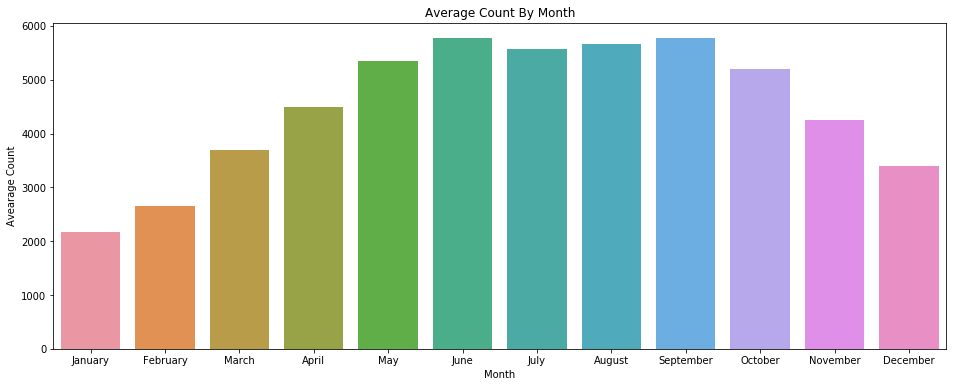

In [16]:

fig,(ax1)= plt.subplots(nrows=1)
fig.set_size_inches(16,6)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(dailyData.groupby("month")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="month",y="cnt",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")



**So we have visualized the data to a greater extent.So lets go and  build some models and see how close we can predict the results.**

## Filling 0's In windspeed Using Random Forest ##

**Lets Read In Train And Test Data**

In [17]:
data = pd.read_csv("day.csv")

**Feature Engineering**

In [18]:
data["weekday"] = data.dteday.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())
data["month"] = data.dteday.apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").month)
data["year"] = data.dteday.apply(lambda x : x.split()[0].split("-")[0])

**Coercing To Categorical Type**

In [19]:
categoricalFeatureNames = ["season","holiday","workingday","weathersit","weekday","month","year"]
numericalFeatureNames = ["temp","hum","windspeed","atemp"]
dropFeatures = ['instant','casual',"dteday","registered",'mnth', 'yr']

In [20]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

In [21]:
dteday = data.dteday
data  = data.drop(dropFeatures,axis=1)

In [22]:
data.head(2)

,season,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,month,year
0,1,0,5,0,2,0.344167,0.363625,0.805833,0.160446,985,1,2011
1,1,0,6,0,2,0.363478,0.353739,0.696087,0.248539,801,1,2011


**Splitting Train And Test Data**

In [23]:
x_vars = list(data.columns)
x_vars.remove('cnt')
print(x_vars)

['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'month', 'year']


In [24]:
from sklearn.model_selection import train_test_split
X = data[x_vars]
Y = data.cnt
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(584, 11) (584,)
(147, 11) (147,)


In [25]:
dataTrain = X_train
yLabels = y_train

**RMSLE Scorer**

In [26]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## **Linear Regression Model** ##

In [27]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Initialize logistic regression model
lModel = LinearRegression()

# Train the model
yLabelsLog = np.log1p(yLabels)
lModel.fit(X = dataTrain,y = yLabelsLog)

# Make predictions
preds = lModel.predict(X= dataTrain)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.34362984831234766


## **Regularization Model -  Ridge** ##

{'alpha': 1, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.34432163148375283


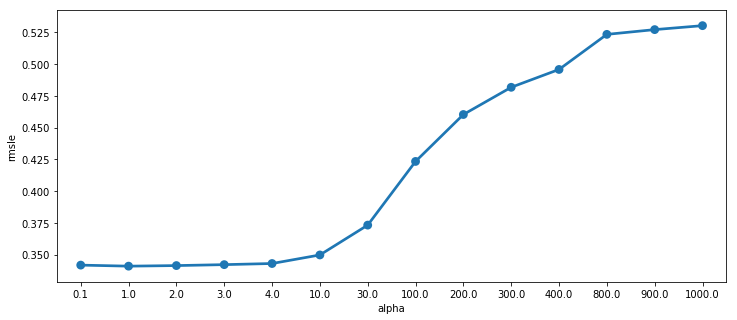

In [28]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5,
                          return_train_score=True)
yLabelsLog = np.log1p(yLabels)
grid_ridge_m.fit( dataTrain, yLabelsLog )
preds = grid_ridge_m.predict(X= dataTrain)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [29]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## **Regularization Model - Lasso** ##

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression:  0.3442459713628952


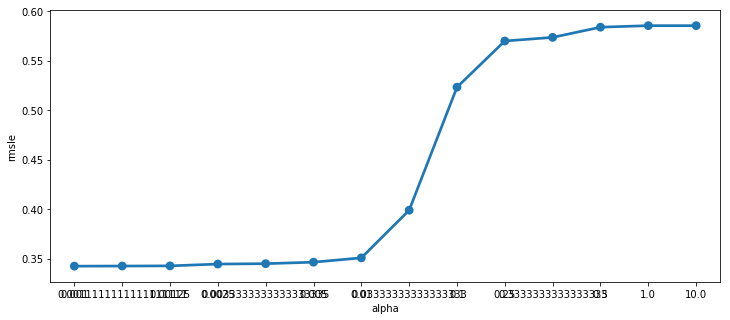

In [30]:
lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5, return_train_score=True)
yLabelsLog = np.log1p(yLabels)
grid_lasso_m.fit( dataTrain, yLabelsLog )
preds = grid_lasso_m.predict(X= dataTrain)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## **Ensemble Models - Random Forest**##

In [31]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=500)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(dataTrain,yLabelsLog)
preds = rfModel.predict(X= dataTrain)
print ("RMSLE Value For Random Forest: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest:  0.10899995853128484


## **Ensemble Model - Gradient Boost** ##

In [32]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=500,alpha=0.01); ### Test 0.41
yLabelsLog = np.log1p(yLabels)
gbm.fit(dataTrain,yLabelsLog)
preds = gbm.predict(X= dataTrain)
print ("RMSLE Value For Gradient Boost: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Gradient Boost:  0.036058642339735825


**Lets compare the distribution of train and test results. More or less the distribution of train and test looks identical. It  confirms visually that our model has not predicted really bad and not suffering from major overfitting problem.**

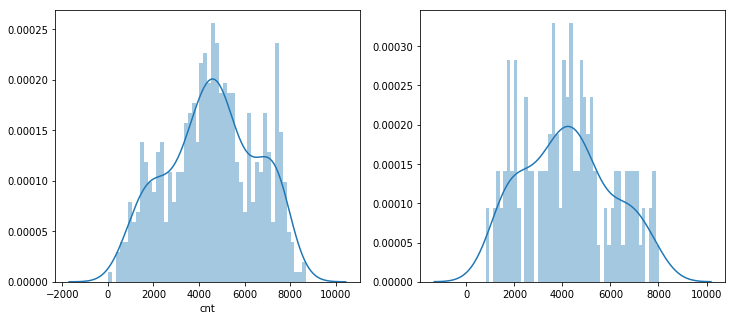

In [33]:
predsTest = gbm.predict(X= X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(yLabels,ax=ax1,bins=50)
sn.distplot(np.exp(predsTest),ax=ax2,bins=50)